# Visualization of inversion results
**Author**  Binbin Liao  
**Date** October 15,2024  

In [2]:
from time import time
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from tqdm import tqdm_notebook
import torch.nn.functional as F
import torch.autograd as autograd
import pandas as pd
import gc
import scipy
import torch.nn.init as init
import seaborn as sns
import torch.distributions
from numpy.random import shuffle

from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import FrEIA.framework as Ff
import FrEIA.modules as Fm
#import sys
#sys.path.append('/home/lenovo/Working/Notebook/Normal_mode_inversion/')

from tools import *

import importlib
import tools
importlib.reload(tools)
from tools import *

import real_inversion_tools
importlib.reload(real_inversion_tools)
from real_inversion_tools import *

import Model_generator
importlib.reload(Model_generator)
from Model_generator import *

#import Nets
#from Nets import *
device = 'cuda' if torch.cuda.is_available() else 'cpu'
from IPython.display import clear_output

In [3]:
# Read the observations
obs_min0 = np.loadtxt('./data/new_obs_min_0.txt')
obs_inter0 = np.loadtxt('./data/new_obs_inter_0.txt')
obs_real = np.loadtxt("./data/new_obs_real.txt")
obs_std = np.loadtxt("./data/new_obs_err.txt")
obs_real = obs_real[:167]
obs_std = obs_std[:167]
obs_t_real = np.array([1.31929,1.43845,1.75019,1.92525,2.10340,
                       3.09907,3.25352,
                      2.29528,2.48487,2.75300,2.91257,3.83052,4.01381,
                      4.19269,4.36875,
                      3.20008,3.60368,5.05139,4.77537])*1000.
obs_t_std = np.array([0.17e-3, 0.08e-3,0.13e-3,0.12e-3,0.06e-3,
                     0.10e-3,0.06e-3,
                    0.22e-3,0.15e-3,0.33e-3,0.08e-3,0.21e-3,0.24e-3,0.22e-3,
                     0.53e-3,
                     1.73e-3,0.24e-3,0.23e-3,1.86e-3])*1000.
obs_real = np.concatenate([obs_real,obs_t_real])
obs_std = np.concatenate([obs_std,obs_t_std])

var_np0 = obs_std/obs_inter0*2.
obs_normal0 = np.loadtxt('./data/new_obs_normal_0.txt')
model_syn0 = np.loadtxt('./data/new_model_syn_0.txt')

In [4]:
#Read normalization parameters
obs_normal_prim = np.loadtxt('./data/new_obs_normal_3.txt')
model_syn_prim = np.loadtxt('./data/new_model_syn_3.txt')
obs_min_prim = np.loadtxt('./data/new_obs_min_3.txt')
obs_inter_prim = np.loadtxt('./data/new_obs_inter_3.txt')

FileNotFoundError: ./data/new_obs_normal_3.txt not found.

In [8]:
obs_std.shape, model_syn0.shape

((186,), (94654, 152))

In [4]:
var_np3 = obs_std/obs_inter_prim*2.
var3 = torch.tensor(obs_std/obs_inter_prim*2.,dtype=torch.float32)

In [10]:
#load the observation's encoder
filename = './net/Obs_normal_3_real.pth'
Obs_Normal_Flow_s3 = Flow(INPUT_SIZE).cuda()
state = torch.load(filename)
Obs_Normal_Flow_s3.load_state_dict(state)
Obs_Normal_Flow_s3.eval();

In [11]:
#load the Earth model's encoder
filename = './net/Mod_normal_3_real.pth'
Mod_Normal_Flow_s3 = Flow(OUTPUT_SIZE).cuda()
state = torch.load(filename)
Mod_Normal_Flow_s3.load_state_dict(state)
Mod_Normal_Flow_s3.eval();

In [12]:
#load the main flow
filename = './net/Inverse_flow_s3_real.pth'
Inverse_flow_s3 = Flow_cond(OUTPUT_SIZE,INPUT_SIZE).cuda()
state = torch.load(filename)
Inverse_flow_s3.load_state_dict(state)
Inverse_flow_s3.eval();

In [31]:
SAMPLE_SIZE = 500
scale = 7.0
ert_mean = np.zeros((SAMPLE_SIZE,OUTPUT_SIZE))
ert_max = np.zeros((SAMPLE_SIZE,OUTPUT_SIZE))
err_dist = torch.distributions.MultivariateNormal(torch.zeros(INPUT_SIZE,dtype=torch.float32),
                                                                    torch.diag(torch.from_numpy(np.power(var_np3*scale,2))).
                                                                    type(torch.float32))
for i in range(SAMPLE_SIZE):
    obs_test = torch.tensor(obs_normal_prim[i],device=device,dtype=torch.float32)
    obs_tensor = torch.randn(BATCH_SIZE,INPUT_SIZE,device=device,dtype=torch.float32)
    obs_tensor[:] = obs_test.reshape(1,INPUT_SIZE)
    error = err_dist.sample((BATCH_SIZE,)).cuda()
    obs_sample_code = Obs_Normal_Flow_s3(obs_tensor+error)[0].detach()
    rand_ert = torch.randn(BATCH_SIZE,OUTPUT_SIZE,device=device) 
    ert_fake_code,jac = Inverse_flow_s3(rand_ert,obs_sample_code,rev=True,jac=False)
    #ert_fake = ert_fake.detach().cpu().numpy()
    #logp = 0.5*torch.sum(rand_ert**2,1)+jac
    #ert_fake = ert_fake.detach().cpu().numpy()
    #ert_max[i] = ert_fake[logp.argmax().item()]
    ert_fake = Mod_Normal_Flow_s3(ert_fake_code,rev=True,jac=False)[0].detach().cpu().numpy()
    ert_mean[i] = ert_fake.mean(axis=0)

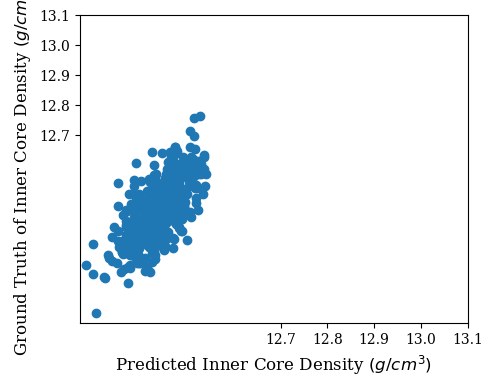

In [41]:
#check the prediction accuracy of Out1 layer's density
Nl = 0
N1 = model_pair['Out1_den']

rx = x[Nl]
den_prem_N1 = den_p[Nl,1]*rx +den_p[Nl,2]*rx*rx+den_p[Nl,3]*rx*rx*rx

ert_true = ref_model+model_syn_prim[:500]*d_model/2.
ert_fake = ref_model+ert_mean[:500]*d_model/2.

den_true = ert_true[:500,N1]+den_prem_N1
den_fake = ert_fake[:500,N1]+den_prem_N1

fig,ax = plt.subplots(figsize=(5.0,4.0))
ax.scatter(den_fake,den_true)
ax.set_ylabel('Ground Truth of Inner Core Density $(g/cm^3)$',fontdict=font)
ax.set_xlabel('Predicted Inner Core Density $(g/cm^3)$',fontdict=font)
ax.set_xticks([12.7,12.8,12.9,13.0,13.1])
ax.set_yticks([12.7,12.8,12.9,13.0,13.1])

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')
#fig.savefig('IC_den.png',dpi=300)

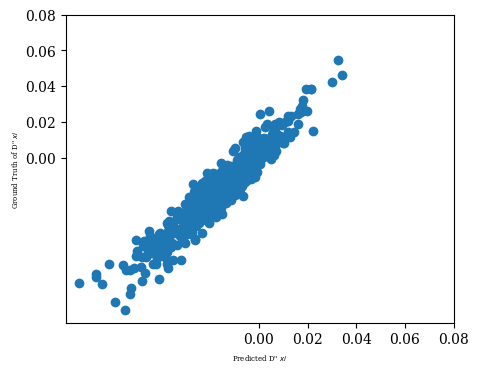

In [100]:
#check the prediction accuracy of Lm1 layer's vsh
Nl = 2
N1 = model_pair['Lm1_vsh']

rx = x[Nl]
vsv_prem_N1 = vsv_p[Nl,1]*rx +vsv_p[Nl,2]*rx*rx+vsv_p[Nl,3]*rx*rx*rx
vsh_prem_N1 = vsh_p[Nl,1]*rx +vsh_p[Nl,2]*rx*rx+vsh_p[Nl,3]*rx*rx*rx

ert_true = ref_model+model_syn_prim[:500]*d_model/2.
ert_fake = ref_model+ert_mean[:500]*d_model/2.

#rx = x[N1]
#vsv_prem_N1 = vsv_p[N1,0] + vsv_p[N1,1]*rx +vsv_p[N1,2]*rx*rx+vsv_p[N1,3]*rx*rx*rx


xi_true = 1- np.power((ert_true[:500,N1]+vsh_prem_N1)/(ert_true[:500,N2]+vsv_prem_N1),2)
xi_fake = 1- np.power((ert_fake[:500,N1]+vsh_prem_N1)/(ert_fake[:500,N2]+vsv_prem_N1),2)
fig,ax = plt.subplots(figsize=(5.0,4.0))

ax.scatter(xi_fake,xi_true)
ax.set_ylabel('Ground Truth of D\" $xi$',fontdict=font)

ax.set_xlabel('Predicted D\" $xi$ ',fontdict=font)
ax.set_xticks([0.0,0.02,0.04,0.06,0.08])
ax.set_yticks([0.0,0.02,0.04,0.06,0.08])

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')
#fig.savefig('D_xi.png',dpi=300)

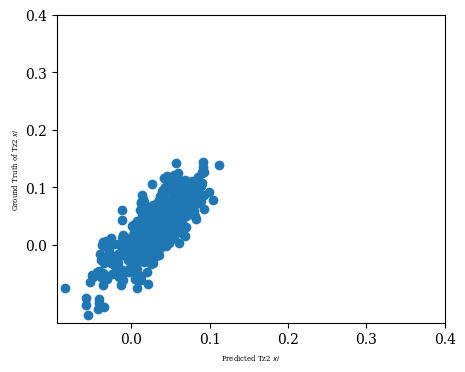

In [43]:
#check the prediction accuracy of Tz2 layer's vsh
N1 = model_pair['Tz2_vsh']

rx = x[Nl]
vsv_prem_N1 = vsv_p[Nl,1]*rx +vsv_p[Nl,2]*rx*rx+vsv_p[Nl,3]*rx*rx*rx
vsh_prem_N1 = vsh_p[Nl,1]*rx +vsh_p[Nl,2]*rx*rx+vsh_p[Nl,3]*rx*rx*rx

ert_true = ref_model+model_syn_prim[:500]*d_model/2.
ert_fake = ref_model+ert_mean[:500]*d_model/2.

#rx = x[N1]
#vsv_prem_N1 = vsv_p[N1,0] + vsv_p[N1,1]*rx +vsv_p[N1,2]*rx*rx+vsv_p[N1,3]*rx*rx*rx


xi_true = 1- np.power((ert_true[:500,N1]+vsh_prem_N1)/(ert_true[:500,N2]+vsv_prem_N1),2)
xi_fake = 1- np.power((ert_fake[:500,N1]+vsh_prem_N1)/(ert_fake[:500,N2]+vsv_prem_N1),2)
fig,ax = plt.subplots(figsize=(5.0,4.0))

ax.scatter(xi_fake,xi_true)
ax.set_ylabel('Ground Truth of Tz2 $xi$',fontdict=font)

ax.set_xlabel('Predicted Tz2 $xi$ ',fontdict=font)
ax.set_xticks([0.0,0.1,0.2,0.3,0.4])
ax.set_yticks([0.0,0.1,0.2,0.3,0.4])

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')
#fig.savefig('Tz2_xi.png',dpi=300)

In [13]:
obs_normal_fin = np.loadtxt('./data/new_obs_normal_3_test.txt')
model_syn_fin = np.loadtxt('./data/new_model_syn_3_test.txt')
obs_min_fin = np.loadtxt('./data/new_obs_min_3_test.txt')
obs_inter_fin = np.loadtxt('./data/new_obs_inter_3_test.txt')

# obs validation

In [8]:
freq_S = np.zeros(544)
filename_S = mineos_path+'/Normal_mode_s5_1_test/Earth_0_S'
filename_T = mineos_path+'/Normal_mode_t5_1_test/Earth_0_T'
a = np.genfromtxt(filename_S)
b = np.genfromtxt(filename_T)
freq_S = a[:,4]*1000.
freq_T = b[:,4]*1000.
obs_mean = np.concatenate([freq_S[freq_indx],freq_T[freq_indx_T]])
diff_mean = obs_mean-obs_real

NameError: name 'font' is not defined

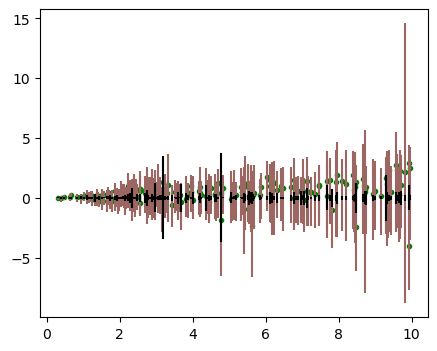

In [16]:
from matplotlib.font_manager import FontProperties
fig,ax = plt.subplots(figsize=(5.0,4.0))
obs_test = (obs_normal_fin+1.)/2.*obs_inter_fin+obs_min_fin
diff_fin = (obs_test-obs_real)
x = obs_real
y1 = diff_fin.std(axis=0)
y2 = diff_fin.mean(axis=0)
sort_index = np.argsort(x)
x_sorted = x[sort_index]
y1_sorted = y1[sort_index]
y2_sorted = y2[sort_index]
obs_std_sorted = obs_std[sort_index]


ymax=y2_sorted+2*y1_sorted
ymin=y2_sorted-2*y1_sorted
x = x_sorted/1000
ymax2 = obs_std_sorted*1.
ymin2 = -obs_std_sorted*1.

ax.vlines(x,ymax,ymin,color=r2,label='posterior pdf')
ax.vlines(x,2*ymax2,2*ymin2,color='k',label='noise')

ax.scatter(x,diff_mean[sort_index],marker='.', color='green',label='mean')

ax.set_ylabel('differences($\mu Hz$)',fontdict=font)
ax.set_xlabel('Frequency($\mu Hz$)',fontdict=font)
ax.set_xticks([0,3,6,9])
ax.set_xticklabels(['0','3k','6k','9k'])
ax.set_yticks([-8,-4,0,4,8])
ax.set_ylim(ymax=8,ymin=-8)

# 创建一个包含字体属性的 FontProperties 对象
font_properties = FontProperties(family='serif', size=10, style='normal')

# 设置图例，并使用 FontProperties 对象设置字体
ax.legend(loc='upper left', prop=font_properties)

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')
#fig.savefig('Real_std_diff.png',dpi=300)

# Posterior pdf

In [18]:
BATCH_SIZE = 256
ert_fake = model_syn_fin[:BATCH_SIZE]

In [19]:
ert_fake.shape

(256, 152)

In [20]:
ert_para = Model_generator.ref_model+ert_fake*Model_generator.d_model/2.

NN=30
nump = 27
nums = 19
r_index = [3,11,12,21,23,24]
vs_index = list((set(range(NN))-set([4,5,6,7,8,9,10,11]))-set([27,28,29]))#13
ot_index = list((set(range(NN))-set([27,28,29])))#17

rad = np.zeros((BATCH_SIZE,NN))
den = np.zeros((BATCH_SIZE,NN))
vpv = np.zeros((BATCH_SIZE,NN))
vsv = np.zeros((BATCH_SIZE,NN))
vph = np.zeros((BATCH_SIZE,NN))
vsh = np.zeros((BATCH_SIZE,NN))
eta = np.zeros((BATCH_SIZE,NN))

rad[:] = Model_generator.rad_p
den[:] = Model_generator.den_p[:,0]
vpv[:] = Model_generator.vpv_p[:,0]
vsv[:] = Model_generator.vsv_p[:,0]
vph[:] = Model_generator.vph_p[:,0]
vsh[:] = Model_generator.vsh_p[:,0]
eta[:] = Model_generator.eta_p[:,0]

rad[:,r_index] = ert_para[:,0:6]
den[:,ot_index] = ert_para[:,6:6+nump]
vpv[:,ot_index] = ert_para[:,6+nump:6+2*nump]
vsv[:,vs_index] = ert_para[:,6+2*nump:6+2*nump+nums]
vph[:,ot_index] = ert_para[:,6+2*nump+nums:6+3*nump+nums]
vsh[:,vs_index] = ert_para[:,6+3*nump+nums:6+3*nump+2*nums]
eta[:,ot_index] = ert_para[:,6+3*nump+2*nums:6+4*nump+2*nums]

In [46]:
# prior pdf
ert_0 = np.loadtxt('./data/new_model_syn_0.txt')

In [13]:
ert_para = Model_generator.ref_model+ert_0[:BATCH_SIZE]*Model_generator.d_model/2.
rad_pr = np.zeros((BATCH_SIZE,NN))
den_pr = np.zeros((BATCH_SIZE,NN))
vpv_pr = np.zeros((BATCH_SIZE,NN))
vsv_pr = np.zeros((BATCH_SIZE,NN))
vph_pr = np.zeros((BATCH_SIZE,NN))
vsh_pr = np.zeros((BATCH_SIZE,NN))
eta_pr = np.zeros((BATCH_SIZE,NN))

rad_pr[:] = Model_generator.rad_p
den_pr[:] = Model_generator.den_p[:,0]
vpv_pr[:] = Model_generator.vpv_p[:,0]
vsv_pr[:] = Model_generator.vsv_p[:,0]
vph_pr[:] = Model_generator.vph_p[:,0]
vsh_pr[:] = Model_generator.vsh_p[:,0]
eta_pr[:] = Model_generator.eta_p[:,0]

rad_pr[:,r_index] = ert_para[:,0:6]
den_pr[:,ot_index] = ert_para[:,6:6+nump]
vpv_pr[:,ot_index] = ert_para[:,6+nump:6+2*nump]
vsv_pr[:,vs_index] = ert_para[:,6+2*nump:6+2*nump+nums]
vph_pr[:,ot_index] = ert_para[:,6+2*nump+nums:6+3*nump+nums]
vsh_pr[:,vs_index] = ert_para[:,6+3*nump+nums:6+3*nump+2*nums]
eta_pr[:,ot_index] = ert_para[:,6+3*nump+2*nums:6+4*nump+2*nums]

In [19]:
depth = 6371-np.array([0]+list(rad_p))

/tmp/ipykernel_963769/919405628.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[iy,ix] = kde(X[iy,ix])


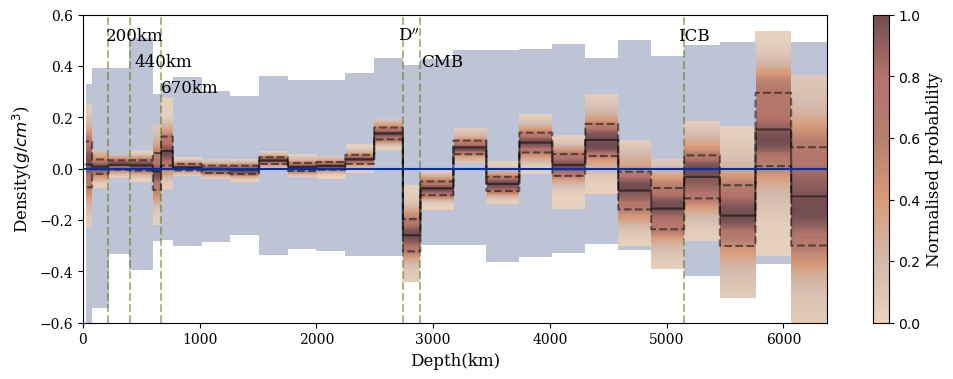

In [62]:
# Posterior pdf of density
fig,ax = plt.subplots(figsize=(12,4))
y_low = 0
y_high = depth[0]
dy = y_high-y_low
ax.set_ylabel('Density($g/cm^3$)',fontdict=font)
ax.set_xlabel('Depth(km)',fontdict=font)
ax.set_xlim([y_low,y_high])
ax.set_ylim([-0.6,0.6])
#ax.invert_xaxis()
#ax.set_xlim([0,100000])
#ax.set_xscale('log')

md = []
mean = []
std = [] 
prem_t = []
diff = []

for i in range(27):
    #kde = gaussian_kde(qk_mc[:,i])
    x1 = 0
    x2 = 20
    y1 = depth[i]
    y2 = depth[i+1]
    Nx = 100
    Ny = 100
    x = np.linspace(x1,x2,Nx)
    y = np.linspace(y1,y2,Ny)
    Z = np.zeros((Ny,Nx))
    Z_pr = np.ones((Ny,Nx))
    X = np.zeros((Ny,Nx))
    X_pr = np.zeros((Ny,Nx))
    for iy in range(Ny):
        r = 6371.-y[iy]
        md.append(y[iy])
        rx = r/6371.
        #den_test = den[:,i] + den_p[i,1]*rx +den_p[i,2]*rx*rx+den_p[i,3]*rx*rx*rx
        den_test = den[:,i]-den_p[i,0]
        mean.append(den_test.mean())
        std.append(den_test.std())
        
        #den_prem = den_p[i,0] + den_p[i,1]*rx +den_p[i,2]*rx*rx+den_p[i,3]*rx*rx*rx
        #prem_t.append(den_prem)
        #diff.append(den_test.mean()-den_prem)
        
        #den_pr_test = den_pr[:,i] + den_p[i,1]*rx +den_p[i,2]*rx*rx+den_p[i,3]*rx*rx*rx
        den_pr_test = den_pr[:,i]-den_p[i,0]
        X[iy,:] = np.linspace(den_test.min(),den_test.max(),Nx)
        X_pr[iy,:] = np.linspace(den_pr_test.min(),den_pr_test.max(),Nx)
    
        kde = gaussian_kde(den_test)
        for ix in range(Nx):
            Z[iy,ix] = kde(X[iy,ix])
        Z[iy,:]=Z[iy,:]/Z[iy,:].max()
    _,Y = np.meshgrid(x,y)
    #Z,Y = np.meshgrid(kde(x),y)
    pcm2 = ax.pcolormesh(Y,X_pr,Z_pr,vmin=0,vmax=1.0,cmap=custom_cmap3)
    pcm1 = ax.pcolormesh(Y,X,Z,vmin=0,vmax=1.0,cmap=custom_cmap_c)
ax.axvline(x=depth[4],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[12],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[13],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[22],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[24],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[25],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)


#ax.plot(den_pf,6371.-rad_pf,color='green',linestyle='-',label='PREM')
#ax.plot(prem_t,md,color='green',label='PREM')
ax.plot(md,mean,color='black',label='Mean',alpha=0.5)
ax.plot(md,np.array(mean)+np.array(std),color='black',linestyle='--',alpha=0.5)
ax.plot(md,np.array(mean)-np.array(std),color='black',linestyle='--',alpha=0.5)
ax.hlines(y=0,xmin=0,xmax=6371,color=(0,50/256,160/256))

#ax.plot(ak_den[6:73],ak_r[6:73],color='r',label='ak135')

#ax2 = ax.twiny()
#ax2.plot(np.array(diff),md,linestyle='-',color='red',label='diff')
#ax2.plot(np.zeros_like(md),md,linestyle='--',color='gray')
#ax2.xaxis.set_ticks_position('top')
#ax2.xaxis.set_label_position('top')
#ax2.set_xlim([-0.2,1.2])
#ax2.set_xticks([-0.2,0,0.2])

#ax.axvline(x=0,ymin=0,ymax=0.01,color=(69/256,75/256,135/256),linestyle='-',label='PREM')
#ax.axvline(x=0,ymin=0,ymax=0.01,color='Black',linestyle='-',label='Posterior')

cbar = plt.colorbar(pcm1,ax=ax,label='Posterior')
cbar.set_label('Normalised probability',fontdict=font)

ax.text(200,0.5,'200km',fontdict=font)
ax.text(440,0.4,'440km',fontdict=font)
ax.text(670,0.3,'670km',fontdict=font)
ax.text(2900,0.4,'CMB',fontdict=font)
ax.text(2700,0.5,'D$\'\'$',fontdict=font)
ax.text(5100,0.5,'ICB',fontdict=font)

#ax.legend(loc='center left')
#ax.axhspan(220,24,facecolor='green',alpha=0.5)
#ax.set_xscale('log')
#ax.set_xticks([100,1000,10000,100000])
ax.grid(False)
#ax.plot(data[:,0],data[:,1])

for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')

#plt.savefig('density_mantle.png',dpi=300)

/tmp/ipykernel_9452/3780701069.py:78: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm2 = ax.pcolormesh(Y,X_pr, Z_pr,vmin=0,vmax=1.0,cmap=custom_cmap3)
/tmp/ipykernel_9452/3780701069.py:79: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm1 = ax.pcolormesh(Y,X,   Z,   vmin=0,vmax=1.0,cmap=custom_cmap_c)


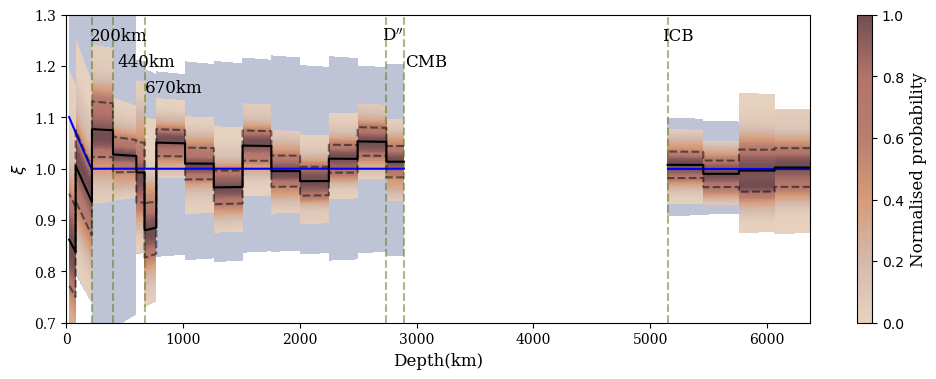

In [140]:
#Posterior pdf of xi
fig,ax = plt.subplots(figsize=(12,4))
y_low = 0
y_high = depth[0]
dy = y_high-y_low
ax.set_ylabel(r'$\xi$',fontdict=font)
ax.set_xlabel('Depth(km)',fontdict=font)
ax.set_xlim([y_low,y_high])
ax.set_ylim([0.7,1.3])


#ax.invert_yaxis()
md1 = []
mean1 = []
std1 = []
prem_t1 = []
md2 = []
mean2 = []
std2 = []
prem_t2 = []
diff = []


for i in range(27):
    if i not in range(4,12):
        x1 = 0
        x2 = 50
        y1 = depth[i]
        y2 = depth[i+1]
        Nx = 100
        Ny = 100
        x = np.linspace(x1,x2,Nx)
        y = np.linspace(y1,y2,Ny)
        Z = np.zeros((Ny,Nx))
        Z_pr = np.ones((Ny,Nx))
        X = np.zeros((Ny,Nx))
        X_pr = np.zeros((Ny,Nx))
        for iy in range(Ny):
            r = 6371.-y[iy]
            if i<4:
                md1.append(y[iy])
            else:
                md2.append(y[iy])
            rx = r/6371.
            vsv_test = vsv[:,i] + vsv_p[i,1]*rx +vsv_p[i,2]*rx*rx+vsv_p[i,3]*rx*rx*rx
            vsh_test = vsh[:,i] + vsh_p[i,1]*rx +vsh_p[i,2]*rx*rx+vsh_p[i,3]*rx*rx*rx
            xi = np.power(vsh_test/vsv_test,2)
            if i <4:
                mean1.append(xi.mean())
                std1.append(xi.std())
            else:
                mean2.append(xi.mean())
                std2.append(xi.std())
                
            vsv_prem = vsv_p[i,0] + vsv_p[i,1]*rx +vsv_p[i,2]*rx*rx+vsv_p[i,3]*rx*rx*rx
            vsh_prem = vsh_p[i,0] + vsh_p[i,1]*rx +vsh_p[i,2]*rx*rx+vsh_p[i,3]*rx*rx*rx
            xi_prem = np.power(vsh_prem/vsv_prem,2)
            if i<4:
                prem_t1.append(xi_prem)
            else:
                prem_t2.append(xi_prem)
            diff.append(xi.mean()-xi_prem)
            
            vsv_pr_test = vsv_pr[:,i] + vsv_p[i,1]*rx + vsv_p[i,2]*rx*rx+ vsv_p[i,3]*rx*rx*rx
            vsh_pr_test = vsh_pr[:,i] + vsh_p[i,1]*rx + vsh_p[i,2]*rx*rx+ vsh_p[i,3]*rx*rx*rx
            xi_pr = np.power(vsh_pr_test/vsv_pr_test,2)
            X_pr[iy,:] = np.linspace(xi_pr.min(),xi_pr.max(),Nx)
            #X_pr[iy,:] = np.linspace(-0.1,0.1,Nx)
            
            X[iy,:] = np.linspace(xi.min(),xi.max(),Nx)
            #vpv_pr_test = vpv_pr[:,i] + vpv_grad_pr[:,i]*rx +vpv_p[i,2]*rx*rx+vpv_p[i,3]*rx*rx*rx
            #X_pr[iy,:] = np.linspace(vpv_pr_test.min(),vpv_pr_test.max(),Nx)
            kde = gaussian_kde(xi)
            for ix in range(Nx):
                Z[iy,ix] = kde(X[iy,ix])[0]
            Z[iy,:]=Z[iy,:]/Z[iy,:].max()
        _,Y = np.meshgrid(x,y)
        #Z,Y = np.meshgrid(kde(x),y)
        pcm2 = ax.pcolormesh(Y,X_pr, Z_pr,vmin=0,vmax=1.0,cmap=custom_cmap3)
        pcm1 = ax.pcolormesh(Y,X,   Z,   vmin=0,vmax=1.0,cmap=custom_cmap_c)
        
    #ax.axvline(x=qk[i][0],ymin=(y_high-y2)/dy,ymax=(y_high-y1)/dy,color=(69/256,75/256,135/256),linestyle='-')
    #ax.axvline(x=qk_ref[i]-d_qk[i]/2.,ymin=(y_high-y2)/dy,ymax=(y_high-y1)/dy,color='yellow',linestyle='--',label='PREM')
    #ax.axvline(x=qk_ref[i]+d_qk[i]/2.,ymin=(y_high-y2)/dy,ymax=(y_high-y1)/dy,color='yellow',linestyle='--',label='PREM')
    #rect = patches.Rectangle((500,0),100,500,facecolor='yellow')
    #rect = patches.Rectangle(((qm_ref[i]-d_qm[i]/2.),(y_high-y1)),d_qm[i],(y1-y2),facecolor='yellow')
    #ax.add_patch(rect)
    #im.set_data(x,y,z)
    #ax.add_image(im)
ax.axvline(x=depth[4],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[13],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[12],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[22],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[24],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[25],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)

ax.plot(md1,prem_t1,color='blue',label='PREM')
ax.plot(md1,mean1,color='black',label='Mean')
ax.plot(md1,np.array(mean1)+np.array(std1),color='black',linestyle='--',alpha=0.5)
ax.plot(md1,np.array(mean1)-np.array(std1),color='black',linestyle='--',alpha=0.5)
ax.plot(md2,prem_t2,color='blue',label='PREM')
ax.plot(md2,mean2,color='black',label='Mean')
ax.plot(md2,np.array(mean2)+np.array(std2),color='black',linestyle='--',alpha=0.5)
ax.plot(md2,np.array(mean2)-np.array(std2),color='black',linestyle='--',alpha=0.5)
#ax2 = ax.twiny()
#ax2.plot(np.array(diff),md,linestyle='-',color='red',label='diff')
#ax2.plot(np.zeros_like(md),md,linestyle='--',color='gray')
#ax2.xaxis.set_ticks_position('top')
#ax2.xaxis.set_label_position('top')
#ax2.set_xlim([-0.15,0.02])
#ax2.set_xticks([-0.01,0,0.01],['-1','0','1'])
#ax2.set_xlabel('diff(%)',fontdict=font)

#.axvline(x=0,ymin=0,ymax=3000)

cbar = plt.colorbar(pcm1,ax=ax,label='Posterior')
cbar.set_label('Normalised probability',fontdict=font)

ax.text(200,1.25,'200km',fontdict=font)
ax.text(440,1.2,'440km',fontdict=font)
ax.text(670,1.15,'670km',fontdict=font)
ax.text(2900,1.2,'CMB',fontdict=font)
ax.text(2700,1.25,'D$\'\'$',fontdict=font)
ax.text(5100,1.25,'ICB',fontdict=font)

#ax.text(1.5,5000,'ICB',fontdict=font)
#ax.legend()
#ax.axhspan(220,24,facecolor='green',alpha=0.5)
#ax.set_xscale('log')
#ax.set_xticks([100,1000,10000,100000])
ax.grid(False)
for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')

plt.savefig('xi_mantle.png',dpi=300)

/tmp/ipykernel_9452/2175664168.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[iy,ix] = kde(X[iy,ix])


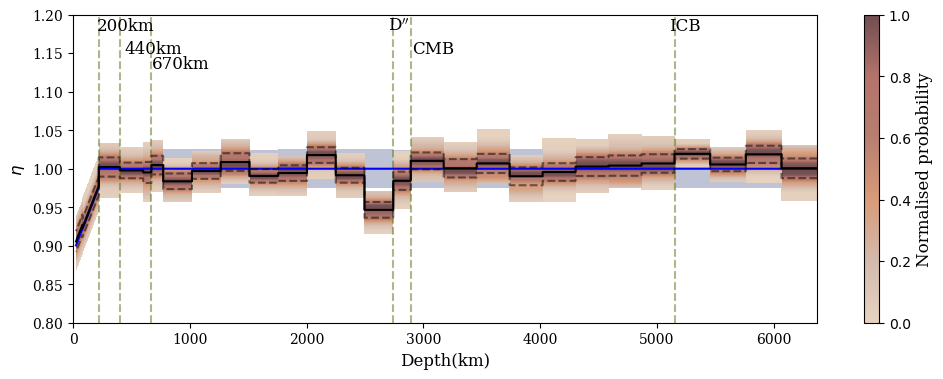

In [142]:
#Posterior pdf of eta
fig,ax = plt.subplots(figsize=(12,4))
y_low = 0
y_high = depth[0]
dy = y_high-y_low
ax.set_ylabel(r'$\eta$',fontdict=font)
ax.set_xlabel('Depth(km)',fontdict=font)
ax.set_xlim([y_low,y_high])
ax.set_ylim([0.8,1.2])
#ax.invert_yaxis()
#ax.set_xlim([0,100000])
#ax.set_xscale('log')

md = []
mean = []
prem_t = []
diff = []
std = []

for i in range(27):
    #kde = gaussian_kde(qk_mc[:,i])
    x1 = 0
    x2 = 20
    y1 = depth[i]
    y2 = depth[i+1]
    Nx = 100
    Ny = 100
    x = np.linspace(x1,x2,Nx)
    y = np.linspace(y1,y2,Ny)
    Z = np.zeros((Ny,Nx))
    Z_pr = np.ones((Ny,Nx))
    X = np.zeros((Ny,Nx))
    X_pr = np.zeros((Ny,Nx))
    for iy in range(Ny):
        r = 6371.-y[iy]
        md.append(y[iy])
        rx = r/6371.
        eta_test = eta[:,i] + eta_p[i,1]*rx 
        mean.append(eta_test.mean())
        std.append(eta_test.std())
        
        eta_prem = eta_p[i,0] + eta_p[i,1]*rx 
        prem_t.append(eta_prem)
        diff.append(eta_test.mean()-eta_prem)
        
        eta_pr_test = eta_pr[:,i] + eta_p[i,1]*rx 
        X[iy,:] = np.linspace(eta_test.min(),eta_test.max(),Nx)
        X_pr[iy,:] = np.linspace(eta_pr_test.min(),eta_pr_test.max(),Nx)
    
        kde = gaussian_kde(eta_test)
        for ix in range(Nx):
            Z[iy,ix] = kde(X[iy,ix])
        Z[iy,:]=Z[iy,:]/Z[iy,:].max()    


    _,Y = np.meshgrid(x,y)
    #Z,Y = np.meshgrid(kde(x),y)
    pcm2 = ax.pcolormesh(Y,X_pr,Z_pr,vmin=0,vmax=1.0,cmap=custom_cmap3)
    pcm1 = ax.pcolormesh(Y,X,Z,vmin=0,vmax=1.0,cmap=custom_cmap_c)
ax.axvline(x=depth[4],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[13],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[12],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[22],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[24],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[25],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)

#ax.axhline(y=depth[1],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
#ax.plot(den_pf,6371.-rad_pf,color='green',linestyle='-',label='PREM')

ax.plot(md,prem_t,color='blue',label='PREM')
ax.plot(md,mean,color='black',label='Mean')
ax.plot(md,np.array(mean)+np.array(std),color='black',linestyle='--',alpha=0.5)
ax.plot(md,np.array(mean)-np.array(std),color='black',linestyle='--',alpha=0.5)

#ax2 = ax.twiny()
#ax2.plot(np.array(diff),md,linestyle='-',color='red',label='diff')
#ax2.plot(np.zeros_like(md),md,linestyle='--',color='gray')
#ax2.xaxis.set_ticks_position('top')
#ax2.xaxis.set_label_position('top')
#ax2.set_xlim([-0.15,0.02])
#ax2.set_xticks([-0.01,0,0.01],['-1','0','1'])
#ax2.set_xlabel('diff(%)',fontdict=font)

#ax.axvline(x=0,ymin=0,ymax=0.01,color=(69/256,75/256,135/256),linestyle='-',label='PREM')
#ax.axvline(x=0,ymin=0,ymax=0.01,color='Black',linestyle='-',label='Posterior')

cbar = plt.colorbar(pcm1,ax=ax,label='Posterior')
cbar.set_label('Normalised probability',fontdict=font)

ax.text(200,1.18,'200km',fontdict=font)
ax.text(440,1.15,'440km',fontdict=font)
ax.text(670,1.13,'670km',fontdict=font)
ax.text(2900,1.15,'CMB',fontdict=font)
ax.text(2700,1.18,'D$\'\'$',fontdict=font)
ax.text(5100,1.18,'ICB',fontdict=font)
#ax.legend(loc='center left')
#ax.axhspan(220,24,facecolor='green',alpha=0.5)
#ax.set_xscale('log')
#ax.set_xticks([100,1000,10000,100000])
ax.grid(False)
for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')

plt.savefig('eta.png',dpi=300)

/tmp/ipykernel_9452/2578282364.py:56: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Z[iy,ix] = kde(X[iy,ix])
/tmp/ipykernel_9452/2578282364.py:59: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm2 = ax.pcolormesh(Y,X_pr,Z_pr,vmin=0,vmax=1.0,cmap=custom_cmap3)
/tmp/ipykernel_9452/2578282364.py:60: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  pcm1 = ax.pcolormesh(Y,X,Z,vmin=0,vmax=1.0,cmap=custom_cmap_c)


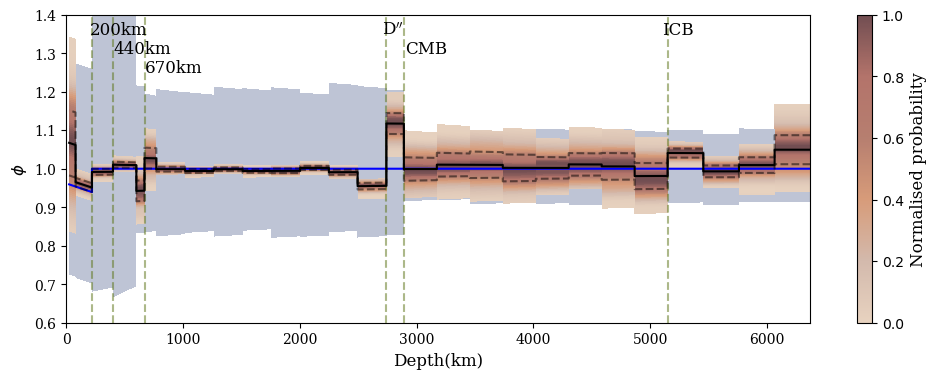

In [146]:
#Posterior pdf of phi
fig,ax = plt.subplots(figsize=(12,4))
y_low = 0
y_high = depth[0]
dy = y_high-y_low
ax.set_ylabel('$\phi$',fontdict=font)
ax.set_xlabel('Depth(km)',fontdict=font)
ax.set_xlim([y_low,y_high])
ax.set_ylim([0.6,1.4])
#ax.invert_yaxis()

md = []
mean = []
prem_t = []
diff = []
std = []

for i in range(27):
    x1 = 0
    x2 = 50
    y1 = depth[i]
    y2 = depth[i+1]
    Nx = 100
    Ny = 100
    x = np.linspace(x1,x2,Nx)
    y = np.linspace(y1,y2,Ny)
    Z = np.zeros((Ny,Nx))
    Z_pr = np.ones((Ny,Nx))
    X = np.zeros((Ny,Nx))
    X_pr = np.zeros((Ny,Nx))
    for iy in range(Ny):
        r = 6371.-y[iy]
        md.append(y[iy])
        
        rx = r/6371.
        vpv_test = vpv[:,i] + vpv_p[i,1]*rx +vpv_p[i,2]*rx*rx+vpv_p[i,3]*rx*rx*rx
        vph_test = vph[:,i] + vph_p[i,1]*rx +vph_p[i,2]*rx*rx+vph_p[i,3]*rx*rx*rx
        phi = np.power(vpv_test/vph_test,2)
        mean.append(phi.mean())
        std.append(phi.std())
        linestyle='--'
        vpv_prem = vpv_p[i,0] + vpv_p[i,1]*rx +vpv_p[i,2]*rx*rx+vpv_p[i,3]*rx*rx*rx
        vph_prem = vph_p[i,0] + vph_p[i,1]*rx +vph_p[i,2]*rx*rx+vph_p[i,3]*rx*rx*rx
        phi_prem =  np.power(vpv_prem/vph_prem,2)
        prem_t.append(phi_prem)
        diff.append(phi.mean()-phi_prem)
        
        X[iy,:] = np.linspace(phi.min(),phi.max(),Nx)
        kde = gaussian_kde(phi)
        
        vpv_pr_test = vpv_pr[:,i] + vpv_p[i,1]*rx +Model_generator.vpv_p[i,2]*rx*rx+Model_generator.vpv_p[i,3]*rx*rx*rx
        vph_pr_test = vph_pr[:,i] + vph_p[i,1]*rx +Model_generator.vph_p[i,2]*rx*rx+Model_generator.vph_p[i,3]*rx*rx*rx
        phi_pr =  np.power(vpv_pr_test/vph_pr_test,2)
        X_pr[iy,:] = np.linspace(phi_pr.min(),phi_pr.max(),Nx)
        
        for ix in range(Nx):
            Z[iy,ix] = kde(X[iy,ix])
        Z[iy,:]=Z[iy,:]/Z[iy,:].max()
    _,Y = np.meshgrid(x,y)
    pcm2 = ax.pcolormesh(Y,X_pr,Z_pr,vmin=0,vmax=1.0,cmap=custom_cmap3)
    pcm1 = ax.pcolormesh(Y,X,Z,vmin=0,vmax=1.0,cmap=custom_cmap_c)
ax.axvline(x=depth[4],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[13],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[12],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[22],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[24],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)
ax.axvline(x=depth[25],color=(91/256,115/256,20/256),linestyle='--',alpha=0.5)

#ax.axvline(x=0,ymin=0,ymax=3000)

#ax2 = ax.twiny()
#ax2.plot(np.array(diff),md,linestyle='-',color='red',label='diff')
#ax2.plot(np.zeros_like(md),md,linestyle='--',color='gray')
#ax2.xaxis.set_ticks_position('top')
#ax2.xaxis.set_label_position('top')
#ax2.set_xlim([-0.15,0.02])
#ax2.set_xticks([-0.04,-0.02,0,0.02],['-4','-2','0','2'])
#ax2.set_xlabel('diff(%)',fontdict=font)

ax.plot(md,prem_t,color='blue',label='PREM')
ax.plot(md,mean,color='black',label='Mean')
ax.plot(md,np.array(mean)+np.array(std),color='black',linestyle='--',alpha=0.5)
ax.plot(md,np.array(mean)-np.array(std),color='black',linestyle='--',alpha=0.5)

ax.text(200,1.35,'200km',fontdict=font)
ax.text(400,1.30,'440km',fontdict=font)
ax.text(670,1.25,'670km',fontdict=font)
ax.text(2900,1.30,'CMB',fontdict=font)
ax.text(2700,1.35,'D$\'\'$',fontdict=font)
ax.text(5100,1.35,'ICB',fontdict=font)


cbar = plt.colorbar(pcm1,ax=ax,label='Posterior')
cbar.set_label('Normalised probability',fontdict=font)
#ax.legend(loc='center left')
for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontname('serif')

plt.savefig('phi_mantle.png',dpi=300)